<a href="https://colab.research.google.com/github/echung2/echung2/blob/master/2024_DH_%EA%B2%A8%EC%9A%B8%ED%95%99%EA%B5%90_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 다양한 토픽 모델 체험해보기
이 실습에서는 동일한 말뭉치에 대해 여러 토픽 모델링 기법을 적용해보면서
각 토픽 모델의 특징과 활용 가능성에 대해 체험해봅니다.


In [ ]:
# 실습에 사용되는 패키지들을 설치합니다.
!pip install kiwipiepy tomotopy nltk pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 34.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.16.0-py3-none-any.whl size=30813256 sha256=f54006495224805580d844f8f940a25832c0e55001d772870ddf71df217b3aa2
  Stored in directory: /root/.cache/pip/wheels/6b/03/2b/ac2c97cc65ebd9df3516f4b900adc2f0a744df8d1375b2e2ef
Successfully built kiwipiepy-model


In [ ]:
# 실습에 사용할 패키지들을 로드합니다.
import kiwipiepy
import tomotopy as tp
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Kiwi는 한국어 형태로 분석에 쓰입니다.
kiwi = kiwipiepy.Kiwi(num_workers=2)

In [ ]:
# 구글 드라이브에서 naver_shopping.txt를 가져옵니다.
# 혹은 https://drive.google.com/file/d/1UkmkPIMGMj7SUWb_uqhLeKepqwnRls3J/view?usp=drive_link 에서 파일을 다운받은뒤
# 직접 업로드하는 방법도 가능합니다.
FILEID = "1UkmkPIMGMj7SUWb_uqhLeKepqwnRls3J"
FILENAME = "naver_shopping.txt"

!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILEID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILEID}" -O {FILENAME} && rm -rf ~/cookies.txt

--2024-01-14 16:01:22--  https://docs.google.com/uc?export=download&confirm=&id=1UkmkPIMGMj7SUWb_uqhLeKepqwnRls3J
Resolving docs.google.com (docs.google.com)... 173.194.195.100, 173.194.195.101, 173.194.195.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.195.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1UkmkPIMGMj7SUWb_uqhLeKepqwnRls3J&export=download [following]
--2024-01-14 16:01:22--  https://drive.usercontent.google.com/download?id=1UkmkPIMGMj7SUWb_uqhLeKepqwnRls3J&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.214.132, 2607:f8b0:4001:c05::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.214.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20623547 (20M) [application/octet-stream]
Saving to: ‘naver_shopping.txt’

naver_shopping.txt  100%[===================>]  19

In [ ]:
# naver_shopping.txt 에서 문서들을 읽어옵니다.
docs = [line.split('\t', 1) for line in open('naver_shopping.txt', encoding='utf-8')]
docs = [(int(score), sent) for score, sent in docs]

In [ ]:
# 읽어온 문서 10개를 출력해봅니다.
docs[:10]

[(5, '배공빠르고 굿\n'),
 (2, '택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고\n'),
 (5, '아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 엉성하긴 하지만 편하고 가성비 최고예요.\n'),
 (2,
  '선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전화했더니 바로주신다했지만 배송도 누락되어있었네요.. 확인안하고 바로 선물했으면 큰일날뻔했네요..이렇게 배송이 오래걸렸으면 사는거 다시 생각했을거같아요 아쉽네요..\n'),
 (5, '민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ\n'),
 (2, '비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적으로 보였는데 생각보다 진짜 별로입니다.\n'),
 (1,
  '주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화도 안되고 아무런 연락을 받을수가 없으니 답답하신 분들은 다른곳에서 사시는거 추천드립니다\n'),
 (2, '넉넉한 길이로 주문했는데도 안 맞네요 별로예요\n'),
 (2, '보폴이 계속 때처럼 나오다가 지금은 안나네요~\n'),
 (2,
  '110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신축성없는 일반실로 되어있어 빅사이즈임에도 빅사이즈같지않아요. 입고벗을때 편하게 밴딩부분이 늘어나고 입었을때도 밴딩이 잡아주어야하는데 말이죠.\n')]

In [ ]:
# Kiwi 형태소 분석기 기반의 토크나이저입니다.
class KoreanTokenizer:
    def __init__(self, kiwi, allowed_tags:list = None, banned_tags:list = None, stopwords:list = None):
        self.kiwi = kiwi
        assert allowed_tags is None or banned_tags is None, 'allowed_tags and banned_tags cannot be used at the same time.'
        self.allowed_tags = set(allowed_tags) if allowed_tags is not None else None
        self.banned_tags = set(banned_tags) if banned_tags is not None else None
        self.stopwords = set(stopwords or [])

    def __call__(self, texts):
        for tokens in self.kiwi.tokenize(text for text, _ in texts):
            if self.allowed_tags is not None:
                tokens = [(token.tagged_form, token.start, token.len) for token in tokens if token.tag in self.allowed_tags and token.tagged_form not in self.stopwords]
            elif self.banned_tags is not None:
                tokens = [(token.tagged_form, token.start, token.len) for token in tokens if token.tag not in self.banned_tags and token.tagged_form not in self.stopwords]
            else:
                tokens = [(token.tagged_form, token.start, token.len) for token in tokens if token.tagged_form not in self.stopwords]
            yield tokens

In [ ]:
# 형태소 분석기의 품사 태그에 관해서는
# https://github.com/bab2min/kiwipiepy?tab=readme-ov-file#%ED%92%88%EC%82%AC-%ED%83%9C%EA%B7%B8
# 를 참조해주세요.
tokenizer = KoreanTokenizer(
    kiwi,
    banned_tags=['EC', 'EF', 'ETN', 'EP', 'ETM',
                 'SF', 'SP', 'SS', 'SSO', 'SSC', 'SE', 'SO', 'SW', 'SB',
                 'Z_CODA',
                 'JKS', 'JKC', 'JKO', 'JKG', 'JC', 'JKB', 'JKV', 'JKV', 'JKQ', 'JX',
                 'XSN', 'XSV', 'XSA',
                 'VCP', 'VCN', 'VX'],
    stopwords=['하/VV', '되/VV']
)
# 형태소 분석기에 사용자 정의 단어를 추가하는 것이 가능합니다.
# Kiwi 사전에 없는 신조어 대박을 NNP로 등록하면 분석시에 '대박'이 잘못 쪼개지지 않고 온전하게 나옵니다.
kiwi.add_user_word('대박', 'NNP')

True

In [ ]:
# 토크나이저의 생성 결과 10개를 샘플로 출력합니다.
tokenized_samples = list(tokenizer((content, None) for score, content in tqdm(docs[:10])))

100%|██████████| 10/10 [00:00<00:00, 30.73it/s]


In [ ]:
tokenized_samples[:10]

[[('배/NNP', 0, 1), ('공/NNG', 1, 1), ('빠르/VA', 2, 2), ('굿/NNG', 6, 1)],
 [('택배/NNG', 0, 2),
  ('엉망/NNG', 4, 2),
  ('저희/NP', 10, 2),
  ('집/NNG', 12, 1),
  ('밑/NNG', 14, 1),
  ('층/NNG', 16, 1),
  ('말/NNG', 19, 1),
  ('없이/MAG', 21, 2),
  ('놔두/VV', 24, 2),
  ('가/VV', 27, 1)],
 [('아주/MAG', 0, 2),
  ('좋/VA', 2, 1),
  ('바지/NNG', 6, 2),
  ('정말/MAG', 9, 2),
  ('좋/VA', 12, 1),
  ('2/SN', 15, 1),
  ('개/NNB', 16, 1),
  ('더/MAG', 18, 1),
  ('구매/NNG', 20, 2),
  ('이/MM', 26, 1),
  ('가격/NNG', 27, 2),
  ('대박/NNP', 31, 2),
  ('바느질/NNG', 38, 3),
  ('조금/MAG', 43, 2),
  ('엉성/XR', 46, 2),
  ('편하/VA', 55, 2),
  ('가성비/NNG', 59, 3),
  ('최고/NNG', 63, 2)],
 [('선물/NNG', 0, 2),
  ('빨리/MAG', 6, 2),
  ('받/VV-R', 9, 1),
  ('전달/NNG', 13, 2),
  ('상품/NNG', 22, 2),
  ('머/IC', 29, 1),
  ('그/MM', 30, 1),
  ('컵/NNG', 31, 1),
  ('오/VV', 34, 1),
  ('당황/NNG', 37, 2),
  ('전화/NNG', 45, 2),
  ('바로/MAG', 51, 2),
  ('주/VV', 53, 1),
  ('배송/NNG', 60, 2),
  ('누락/NNG', 64, 2),
  ('확인/NNG', 75, 2),
  ('안/MAG', 77, 1),
  ('바로/MAG', 81, 2)

In [ ]:
# 토픽 모델링에 사용할 문서들 전체를 Corpus로 묶습니다.
corpus = tp.utils.Corpus(tokenizer=tokenizer)
# 실습 시간 관계상 10000개 문서만 사용합니다.
# 문서에 본문과 평점이 함께 들어가 있으므로 평점은 numeric_metadata로 등록합니다.
corpus.process((content, None, {'numeric_metadata': [score]}) for score, content in tqdm(docs[:10000]))

100%|██████████| 10000/10000 [00:08<00:00, 1158.77it/s]


10000

# LDA 모델
가장 기본적인 토픽 모델.
대량의 말뭉치(문서의 집합으로 각 문서는 단어들의 조합으로 구성되어 있음)를 문서-토픽(Document-Topic), 토픽-단어(Topic-Term) 간의 관계로 분해하는 역할을 수행.

In [ ]:
# LDA 토픽 모델을 생성합니다.
# k: 주제의 개수. 연구자가 적절한 수치로 선택해야 합니다. 이에 대해서는 별도로 더 설명할 예정입니다.
# min_df: 이 숫자보다 적은 개수의 문서에만 등장하는 어휘는 학습에서 배제시킵니다.
#         극히 소수의 문서에서만 등장하는 어휘는 최종 결과에 노이즈로만 작용하므로 배제하는게 좋습니다.
# tw: 용어 가중치 부여 방법. tp.TermWeight.ONE, tp.TermWeight.IDF, tp.TermWeight.PMI 중 하나를 선택할 수 있습니다.
#     생략할 경우 tp.TermWeight.ONE이 기본값으로 선택됩니다.
model = tp.LDAModel(k=20, min_df=5, tw=tp.TermWeight.PMI, corpus=corpus)

In [ ]:
model.train(0)
model.summary(topic_word_top_n=10)

<Basic Info>
| LDAModel (current version: 0.12.7)
| 10000 docs, 98008 words
| Total Vocabs: 9558, Used Vocabs: 2330
| Entropy of words: 6.44291
| Entropy of term-weighted words: 7.05069
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 0, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -9.53429
|
<Initial Parameters>
| tw: TermWeight.PMI
| min_cf: 0 (minimum collection frequency of words)
| min_df: 5 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 144471222 (random seed)
| trained in version 0.12.7
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.1 0.1 0.1 

In [ ]:
model.train(1000, workers=2, show_progress=True)

Iteration: 100%|██████████| 1000/1000 [00:13<00:00, 73.00it/s, LLPW: -6.518131]


In [ ]:
model.summary(topic_word_top_n=10)

<Basic Info>
| LDAModel (current version: 0.12.7)
| 10000 docs, 98008 words
| Total Vocabs: 9558, Used Vocabs: 2330
| Entropy of words: 6.44291
| Entropy of term-weighted words: 7.05069
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 1000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -6.51512
|
<Initial Parameters>
| tw: TermWeight.PMI
| min_cf: 0 (minimum collection frequency of words)
| min_df: 5 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 144471222 (random seed)
| trained in version 0.12.7
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.0403565

In [ ]:
# Google Colab에서 Viewer를 실행시에는 다음의 print문에서 출력되는 주소로 접속해야 합니다.
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(8000)"))
# 토픽 모델링 결과를 살펴볼 수 있는 뷰어를 8000포트에 띄웁니다.
tp.viewer.open_viewer(model, port=8000)

https://tndmjso3mng-496ff2e9c6d22116-8000-colab.googleusercontent.com/
Serving a topic model viewer at http://127.0.0.1:8000/


127.0.0.1 - - [14/Jan/2024 16:02:27] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Jan/2024 16:02:28] code 404, message Not Found
127.0.0.1 - - [14/Jan/2024 16:02:28] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [14/Jan/2024 16:02:30] "GET /document HTTP/1.1" 200 -
127.0.0.1 - - [14/Jan/2024 16:02:31] code 404, message Not Found
127.0.0.1 - - [14/Jan/2024 16:02:31] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [14/Jan/2024 16:02:32] "GET /topic HTTP/1.1" 200 -
127.0.0.1 - - [14/Jan/2024 16:02:33] code 404, message Not Found
127.0.0.1 - - [14/Jan/2024 16:02:33] "GET /favicon.ico HTTP/1.1" 404 -


KeyboardInterrupt: 

# G-DMR 모델
LDA와 거의 유사하지만, 각 문서에 연속형 혹은 범주형의 추가 메타데이터가 붙어 있는 경우를 고려한다(예를 들어 각 문서에 평점이나 작성 시간, 저자, 출판사 등과 같은 정보). G-DMR 모델은 문서-토픽, 토픽-단어 관계뿐만 아니라, 메타데이터-토픽 간의 관계까지 추출해내는 것이 가능.

In [ ]:
model = tp.GDMRModel(k=20, min_df=5, tw=tp.TermWeight.PMI, degrees=[2], corpus=corpus)

In [ ]:
model.train(0)
model.summary(topic_word_top_n=10)

<Basic Info>
| GDMRModel (current version: 0.12.7)
| 10000 docs, 98008 words
| Total Vocabs: 9558, Used Vocabs: 2330
| Entropy of words: 6.44291
| Entropy of term-weighted words: 7.05069
| Removed Vocabs: <NA>
| Numeric metadata distribution of docs
|  #0: Range=1.0~5.0, Avg=3.2152, Stdev=1.6407
|
<Training Info>
| Iterations: 0, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -9.53556
|
<Initial Parameters>
| tw: TermWeight.PMI
| min_cf: 0 (minimum collection frequency of words)
| min_df: 5 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| degrees: [2] (a list of the degrees of Legendre polynomials for TDF(Topic Distribution Function))
| alpha: [0.1] (exponential of mean of normal distribution for `lambdas`, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet d

In [ ]:
# 실제로 모델을 학습합니다.
# 학습이 진행되면서 모델의 Log Likelihood per word(LLPW)는 대체로 증가하는 경향을 보입니다.
# 이론적으로는 이 LLPW가 더 이상 증가하지 않는 지점까지 학습을 계속하는 것이 맞지만
# 이번 실습에서는 총 1000 iteration까지만 학습을 진행합니다.
# 데이터셋의 종류나 크기, 구성 등에 따라 LLPW가 더 빠르게 수렴을 하는 경우도 있고
# 더 느리게 수렴하는 경우도 있어서 직접 학습을 돌리고 결과를 보면서 판단하는게 필요합니다.
model.train(1000, workers=2, show_progress=True)

Iteration: 100%|██████████| 1000/1000 [00:53<00:00, 18.85it/s, LLPW: -6.503882]


In [ ]:
model.summary(topic_word_top_n=10)

<Basic Info>
| GDMRModel (current version: 0.12.7)
| 10000 docs, 98008 words
| Total Vocabs: 9558, Used Vocabs: 2330
| Entropy of words: 6.44291
| Entropy of term-weighted words: 7.05069
| Removed Vocabs: <NA>
| Numeric metadata distribution of docs
|  #0: Range=1.0~5.0, Avg=3.2152, Stdev=1.6407
|
<Training Info>
| Iterations: 1000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -6.50603
|
<Initial Parameters>
| tw: TermWeight.PMI
| min_cf: 0 (minimum collection frequency of words)
| min_df: 5 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| degrees: [2] (a list of the degrees of Legendre polynomials for TDF(Topic Distribution Function))
| alpha: [0.1] (exponential of mean of normal distribution for `lambdas`, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichle

In [ ]:
md_start = 1
md_end = 5
md_step = 9
tdf = model.tdf_linspace([md_start], [md_end], [md_step])

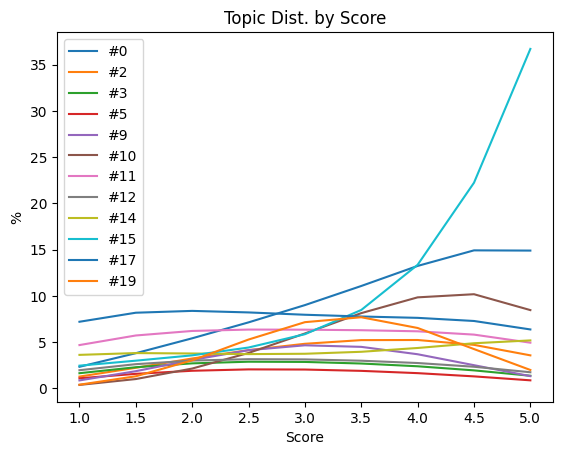

In [ ]:
x = np.linspace(md_start, md_end, md_step)
# 우상향하는 계열만 그리기
for i, y in enumerate(tdf.T):
  if y[:len(y)//2].sum() > y[-len(y)//2:].sum(): continue
  plt.plot(x, y * 100, label=f"#{i}")

plt.plot()
plt.xlabel("Score")
plt.ylabel("%")
plt.title("Topic Dist. by Score")
plt.legend()
plt.show()

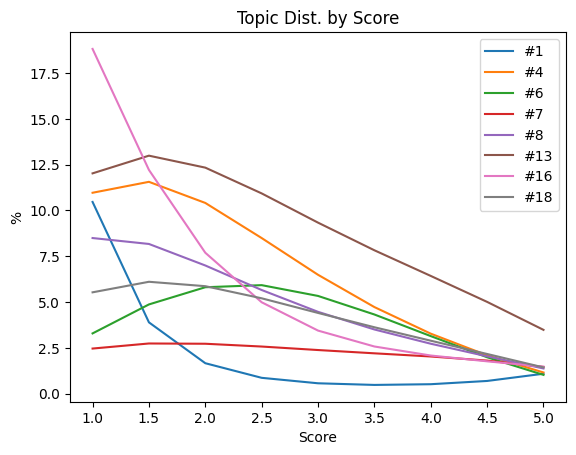

In [ ]:
x = np.linspace(md_start, md_end, md_step)
# 우하향하는 계열만 그리기
for i, y in enumerate(tdf.T):
  if y[:len(y)//2].sum() <= y[-len(y)//2:].sum(): continue
  plt.plot(x, y * 100, label=f"#{i}")

plt.plot()
plt.xlabel("Score")
plt.ylabel("%")
plt.title("Topic Dist. by Score")
plt.legend()
plt.show()

# Correlated Topic 모델
LDA모델과 유사하지만, 토픽과 토픽 간의 관계를 고려하는 모델. 문서-토픽, 토픽-단어 관계뿐만 아니라 어떤 토픽들이 주로 함께 등장하는지, 혹은 함께 등장하지 않는지를 파악하는 것이 가능.

In [ ]:
model = tp.CTModel(k=20, min_df=5, tw=tp.TermWeight.PMI, corpus=corpus)

In [ ]:
model.train(0)
model.summary(topic_word_top_n=10)

<Basic Info>
| CTModel (current version: 0.12.7)
| 10000 docs, 98008 words
| Total Vocabs: 9558, Used Vocabs: 2330
| Entropy of words: 6.44291
| Entropy of term-weighted words: 7.05069
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 0, Burn-in steps: 0
| Optimization Interval: 2
| Log-likelihood per word: -8.69143
|
<Initial Parameters>
| tw: TermWeight.PMI
| min_cf: 0 (minimum collection frequency of words)
| min_df: 5 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| smoothing_alpha: [0.1] (small smoothing value for preventing topic counts to be zero, given as a single `float` in case of symmetric and as a list with length `k` of `float` in case of asymmetric.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 3558440197 (random seed)
| trained in version 0.12.7
|
<Parameters>
| prior_mean (Prior mean of Logit-normal for the per-document topic distributions)
|

In [ ]:
# 실습에서는 빠른 학습을 위해서 num_beta_sample을 1로 설정합니다.
# 문서의 개수가 수 백개 이하로 적은 경우에는 이 값을 5~10 정도로 설정해야 모델이 발산하지 않습니다.
model.num_beta_sample = 1
# 시간 관계상 iteration 역시 300회만 돌도록 합니다.
model.train(300, workers=2, show_progress=True)

Iteration: 100%|██████████| 300/300 [01:32<00:00,  3.25it/s, LLPW: -6.282325]


In [ ]:
model.summary(topic_word_top_n=10)

<Basic Info>
| CTModel (current version: 0.12.7)
| 10000 docs, 98008 words
| Total Vocabs: 9558, Used Vocabs: 2330
| Entropy of words: 6.44291
| Entropy of term-weighted words: 7.05069
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 300, Burn-in steps: 0
| Optimization Interval: 2
| Log-likelihood per word: -6.28166
|
<Initial Parameters>
| tw: TermWeight.PMI
| min_cf: 0 (minimum collection frequency of words)
| min_df: 5 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| smoothing_alpha: [0.1] (small smoothing value for preventing topic counts to be zero, given as a single `float` in case of symmetric and as a list with length `k` of `float` in case of asymmetric.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 3558440197 (random seed)
| trained in version 0.12.7
|
<Parameters>
| prior_mean (Prior mean of Logit-normal for the per-document topic distributions)

In [ ]:
# 상관관계가 큰 토픽 쌍을 찾아서 출력해줍니다.
correlations = model.get_correlations()
k = len(correlations)
idx = (-np.abs(correlations - np.eye(k))).flatten().argsort()
for topic_a, topic_b in zip(idx // k, idx % k):
  if topic_a >= topic_b: continue
  cr = correlations[topic_a, topic_b]
  if abs(cr) < 0.1: break
  print(f"Correlation between #{topic_a} and #{topic_b}: {cr:.5f}")

# 상관 계수가 음수인 것은 한 주제가 등장하면 다른 주제는 등장하지 않는 경향성이 있다는 뜻이며
# 반대로 양수인 것은 한 주제가 등장하면 다른 주제가 등장할 경향성이 있다는 뜻입니다.
# 상관 계수가 0에 가까우면 두 주제는 서로 영향을 미치지 않는다는 뜻입니다.

Correlation between #18 and #19: -0.23251
Correlation between #13 and #16: -0.22870
Correlation between #3 and #18: -0.22321
Correlation between #14 and #17: -0.21559
Correlation between #5 and #14: -0.20294
Correlation between #10 and #18: -0.18754
Correlation between #7 and #14: -0.18478
Correlation between #6 and #15: -0.17378
Correlation between #4 and #14: -0.16602
Correlation between #11 and #18: -0.16585
Correlation between #15 and #19: -0.15074
Correlation between #16 and #19: -0.14545
Correlation between #2 and #18: -0.13447
Correlation between #0 and #18: -0.12947
Correlation between #11 and #14: -0.11727
Correlation between #9 and #19: -0.11513
Correlation between #17 and #19: -0.10824
Correlation between #8 and #16: -0.10295
